In [187]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import seaborn as sns
import configs
import os
import torch
from scipy.stats import pearsonr
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR  
import deer.controllers as bc 
import yaml
from scipy.stats import pearsonr
from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy  

In [188]:
from deer.environments.Figure8 import MyEnv as Env

In [294]:
engram_dir = '/Volumes/aronov-locker/Ching/rl/'
internal_dim = 10
generic_exp_name = 'noisy_altT_eps0.5_volweight' #'noisy_altT_eps0.5_volweight' #'noisy_altT'
exp_name = f'{generic_exp_name}_dm_dim{internal_dim}'
latents_dir = f'{engram_dir}latents/{exp_name}/'
nnets_dir = f'{engram_dir}nnets/{exp_name}/'
pickle_dir = f'{engram_dir}pickles/{exp_name}/'

# Gather experiment data (unused)

In [259]:
def get_df(pfiles):
    results = {'fname': [], 'scores': []}
    for pfile in pfiles:
        with open(pfile, 'rb') as f:
            _results = pickle.load(f)
        n_models = len(_results['fname'])
        for idx in range(n_models):
            results['fname'].append(_results['fname'][idx])
            results['scores'].append(
                _results['valid_scores'][idx][-1])
    return results

In [260]:
pfiles = []
for pfile in os.listdir(pickle_dir):
    pfiles.append(f'{pickle_dir}{pfile}')
results = get_df(pfiles)

# Run test experiments

In [295]:
corr = []
stem_loc = []
score = []
model = []
for model_name in os.listdir(nnets_dir):
    print(model_name)
    if 'altT' not in model_name: continue
    if ('mf' not in model_name) and ('mb' not in model_name): continue
    fname = f'{generic_exp_name}_mb' if 'mb' in model_name else f'{generic_exp_name}_mf'
    #fname = f'noisy_altT_mb' if 'mb' in model_name else f'noisy_altT_mf'
    
    with open(f'{engram_dir}params/{fname}.yaml', 'r') as f:
        parameters = yaml.safe_load(f)
    parameters['fname'] = f'{exp_name}/{model_name}'
    parameters['internal_dim'] = internal_dim
    env = Env(                                                                     
        give_rewards=parameters['figure8_give_rewards'],                           
        higher_dim_obs=parameters['higher_dim_obs'],                               
        show_rewards=parameters['show_rewards'], plotfig=False,
        add_obs_noise=False
        ) 
    rng = np.random.RandomState()
    learning_algo = CRAR(                                                          
        env, parameters['freeze_interval'], parameters['batch_size'], rng,         
        internal_dim=parameters['internal_dim'], lr=parameters['learning_rate'],
        nn_yaml=parameters['nn_yaml'], yaml_mods=parameters['yaml_mods'],          
        double_Q=True, loss_weights=parameters['loss_weights'],                    
        encoder_type=parameters['encoder_type'], mem_len=parameters['mem_len'],
        train_len=parameters['train_len']  
        )   
    train_policy = EpsilonGreedyPolicy(                                     
        learning_algo, env.nActions(), rng, epsilon=1.)             
    test_policy = EpsilonGreedyPolicy(                                      
        learning_algo, env.nActions(), rng, 0.)  
    agent = NeuralAgent(                                                        
        env, learning_algo, parameters['replay_memory_size'], 1,                
        parameters['batch_size'], rng, save_dir=engram_dir,                     
        train_policy=train_policy, test_policy=test_policy)
    agent.attach(bc.LearningRateController(                                     
        initial_learning_rate=parameters['learning_rate'],                      
        learning_rate_decay=parameters['learning_rate_decay'],                  
        periodicity=1))                                                         
    agent.attach(bc.TrainerController(                                          
        evaluate_on='action',  periodicity=parameters['update_frequency'],      
        show_episode_avg_V_value=True, show_avg_Bellman_residual=True))         
    best_controller = bc.FindBestController(                                    
        validationID=Env.VALIDATION_MODE, testID=None, unique_fname=fname)      
    agent.attach(best_controller)                                               
    agent.attach(bc.InterleavedTestEpochController(                             
        id=Env.VALIDATION_MODE, epoch_length=parameters['steps_per_test'],      
        periodicity=1, show_score=True, summarize_every=10, unique_fname=fname))
    try:
        agent.setNetwork(parameters['fname'] + '/fname', nEpoch=40)
    except:
        print(f'Skipping {model_name}')

    agent._in_episode = True
    agent._mode = 0 # Testing mode with plan_depth=0
    initState = env.reset(agent._mode)
    inputDims = env.inputDimensions()
    for i in range(len(inputDims)):
        if inputDims[i][0] > 1:
            agent._state[i][1:] = initState[i][1:]
    agent._Vs_on_last_episode = []
    is_terminal = False
    reward = 0

    xs = []
    ys = []
    latents = []
    reward_locs = []
    for i in range(100):
        obs = env.observe()
        for i in range(len(obs)):
            agent._state[i] = obs[i]    

            state = torch.as_tensor(agent._state).float()
            zs = torch.as_tensor(agent._latent).float()
            latent = agent._learning_algo.crar.encoder(state, zs=zs)
            latent = latent.detach().cpu().numpy()
            loc = list(np.unravel_index(
                np.argmax(obs[i]), obs[i].shape))
            xs.append(loc[0]-1)
            ys.append(loc[1]-1)
            latents.append(latent)
            reward_locs.append(env._reward_location)
            agent._latent[0, 0:-1] = agent._latent[0, 1:]
            agent._latent[0, -1] = latent

        V, action, reward_received = agent._step()
        reward += reward_received
        agent._Vs_on_last_episode.append(V)
        is_terminal = env.inTerminalState()
        if is_terminal: break     
    xs = np.array(xs)
    ys = np.array(ys)
    latents = np.array(latents).squeeze()
    reward_locs = np.array(reward_locs)
    
    # Record results
    midwidth = env.WIDTH//2
    for y in range(4):
        idxs = np.logical_and(xs==midwidth, ys==y)
        right_idxs = np.logical_and(idxs, reward_locs==env.RIGHT_REWARD)
        left_idxs = np.logical_and(idxs, reward_locs==env.LEFT_REWARD)
        try:
            _corr = pearsonr(
                np.mean(latents[right_idxs], axis=0),
                np.mean(latents[left_idxs], axis=0))[0]
            _corr = abs(_corr)
        except:
            continue
        corr.append(_corr)
        stem_loc.append(y)
        score.append(reward)
        model.append(fname)

noisy_altT_eps0.5_volweight_mf_10
noisy_altT_eps0.5_volweight_mb_1
noisy_altT_eps0.5_volweight_mb_7
noisy_altT_eps0.5_volweight_mf_3
noisy_altT_eps0.5_volweight_mb_11
noisy_altT_eps0.5_volweight_mb_14
noisy_altT_eps0.5_volweight_mf_1
noisy_altT_eps0.5_volweight_mf_7
noisy_altT_eps0.5_volweight_mb_6
noisy_altT_eps0.5_volweight_mf_11
noisy_altT_eps0.5_volweight_mb_13
noisy_altT_eps0.5_volweight_mb_4
noisy_altT_eps0.5_volweight_mf_14
noisy_altT_eps0.5_volweight_mf_9
noisy_altT_eps0.5_volweight_mb_2
noisy_altT_eps0.5_volweight_mf_5
noisy_altT_eps0.5_volweight_mf_13
noisy_altT_eps0.5_volweight_mf_4
noisy_altT_eps0.5_volweight_mf_12


/Users/chingfang/miniforge3/envs/auxrl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chingfang/miniforge3/envs/auxrl/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


noisy_altT_eps0.5_volweight_mb_0
noisy_altT_eps0.5_volweight_mb_10
noisy_altT_eps0.5_volweight_mb_15
noisy_altT_eps0.5_volweight_mf_8
noisy_altT_eps0.5_volweight_mb_12
noisy_altT_eps0.5_volweight_mf_6
noisy_altT_eps0.5_volweight_mb_3
noisy_altT_eps0.5_volweight_mf_0
noisy_altT_eps0.5_volweight_mb_9
noisy_altT_eps0.5_volweight_mf_2
noisy_altT_eps0.5_volweight_mf_15
noisy_altT_eps0.5_volweight_mb_5
noisy_altT_eps0.5_volweight_mb_8


In [296]:
%matplotlib inline
df = pd.DataFrame({
    'score': score, 'corr': corr, 'model': model, 'stem_loc': stem_loc
    })

In [297]:
df[(df['model']=='noisy_altT_eps0.5_volweight_mb') & (df['stem_loc']==0)]

,score,corr,model,stem_loc
4,19,0.132186,noisy_altT_eps0.5_volweight_mb,0
8,20,0.041007,noisy_altT_eps0.5_volweight_mb,0
16,18,0.207267,noisy_altT_eps0.5_volweight_mb,0
20,19,0.577064,noisy_altT_eps0.5_volweight_mb,0
32,19,0.198395,noisy_altT_eps0.5_volweight_mb,0
40,19,0.326683,noisy_altT_eps0.5_volweight_mb,0
44,19,0.465399,noisy_altT_eps0.5_volweight_mb,0
56,16,0.754287,noisy_altT_eps0.5_volweight_mb,0
72,17,0.388378,noisy_altT_eps0.5_volweight_mb,0
76,17,0.216244,noisy_altT_eps0.5_volweight_mb,0


(0.0, 1.0)

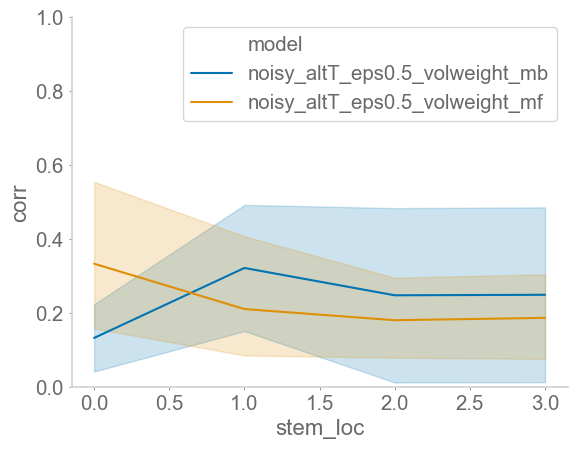

In [298]:
fig, ax = plt.subplots()
sns.lineplot(
    x='stem_loc', y='corr', hue='model',
    ax=ax,
    data=df[df['score']==20],
    )
ax.set_ylim(0,1.)

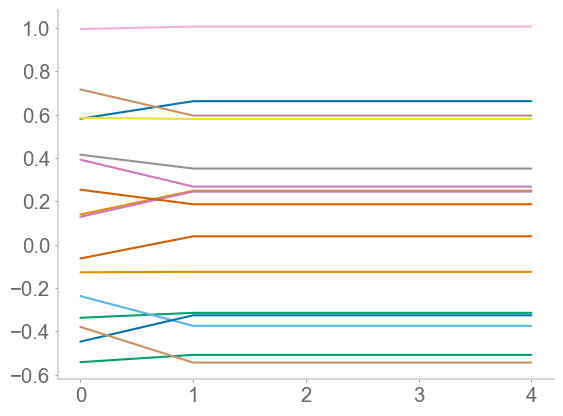

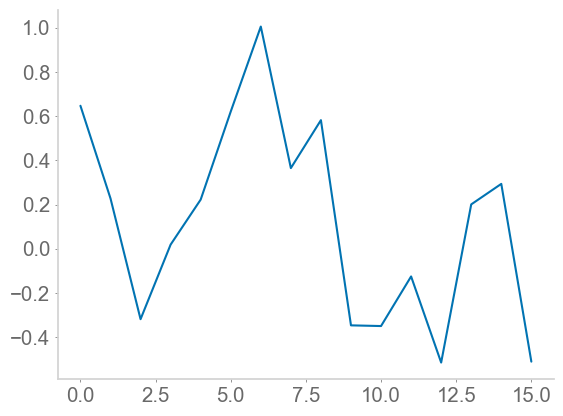

In [72]:
idxs = np.logical_and(xs==0, ys==2)
%matplotlib inline
plt.figure()
plt.plot(latents[idxs])
plt.show()

plt.figure()
plt.plot(np.mean(latents[idxs], axis=0))
plt.show()

In [73]:
midwidth = Env.WIDTH//2
idxs = np.logical_and(
    xs==midwidth, ys==0)
right_idxs = np.logical_and(idxs, reward_locs==Env.RIGHT_REWARD)
left_idxs = np.logical_and(idxs, reward_locs==Env.LEFT_REWARD)

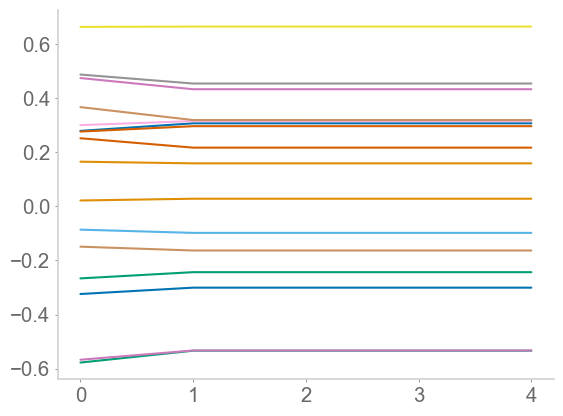

In [74]:
%matplotlib inline
plt.figure()
plt.plot(latents[right_idxs])
plt.show()

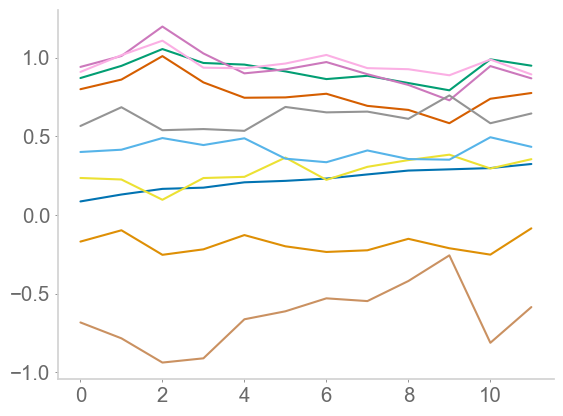

In [59]:
%matplotlib inline
plt.figure()
plt.plot(latents[left_idxs])
plt.show()

In [42]:
np.unique(results['ys'])

array([0, 1, 2, 3])

In [15]:
results['latents'].shape

(250, 10)

In [36]:
Env.RIGHT_REWARD

1

In [37]:
Env.RESET_REWARD

2

In [38]:
Env.LEFT_REWARD

0

In [39]:
Env.HEIGHT

4

In [40]:
Env.WIDTH

5